# Object detection in drawings


*   Sparate components by HSV color space
*   Object detection using template matching
*   Object detection using feature matching

*ILO:* Through this tutorial, we hope you can grasp the basic idea of using template matching and feature matching for object detection in MEP drawings.
<br>

<img src="https://github.com/CrossStyle/MEP2BIM/blob/main/img/CAD-1.png?raw=true" width="600">



## Separate drawings with different colors



### Load and show a image

In [ ]:
# import relevent libraries
from PIL import Image
import matplotlib.pyplot as plt
import urllib.request
import cv2
import numpy as np
import copy

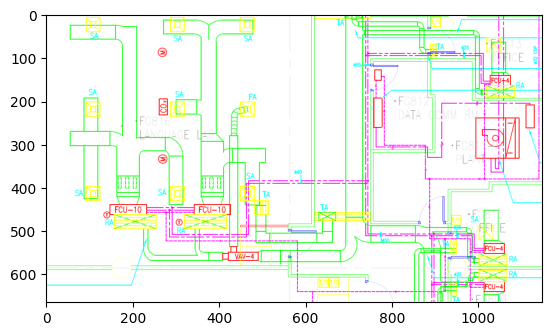

In [ ]:
# load an image of a drawing
req = urllib.request.urlopen("https://github.com/CrossStyle/MEP2BIM/blob/main/img/CAD-1.png?raw=true")
raw_img = np.asarray(bytearray(req.read()), dtype="uint8")
raw_img = cv2.imdecode(raw_img, cv2.IMREAD_COLOR)

img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

### Sparate components by HSV color space

The HSV color space is commonly used in image processing. It is close to our perceptual experience of color and provides a very intuitive representation of the hue, vividness, and lightness of colors. It is not difficult to track objects of a certain color in HSV color space.

The HSV representation of a color image consists of three parts:

1.   Hue: [0, 180]
2.   Saturation: [0, 255]
2.   Value: [0, 255]


![preview](https://pic1.zhimg.com/v2-e9f9c843e7d60e8f7aa7de1cd61d1818_r.jpg)


![enter image description here](https://i.stack.imgur.com/TSKh8.png)


In [ ]:
# convert image from RGB to HSV color space
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

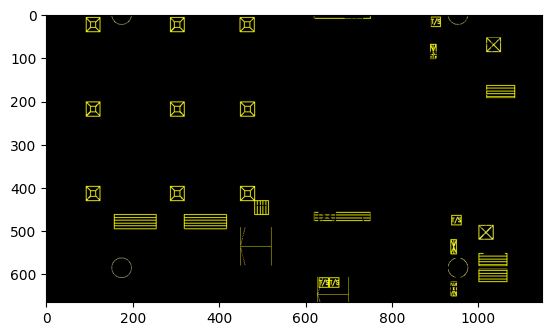

In [ ]:
# Yellow
# H 15-36 S 40-255 V 40-255
mask_yellow = cv2.inRange(hsv, np.array([15, 40, 40]), np.array([36, 255, 255]))
img_yellow = cv2.bitwise_and(img, img, mask=mask_yellow)
plt.imshow(img_yellow)

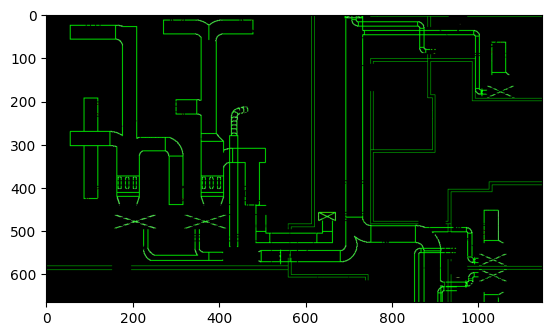

In [ ]:
# Green [40, 70]
# H 15-36 S 40-255 V 40-255
mask_yellow = cv2.inRange(hsv, np.array([40, 40, 40]), np.array([70, 255, 255]))
img_yellow = cv2.bitwise_and(img, img, mask=mask_yellow)
plt.imshow(img_yellow)


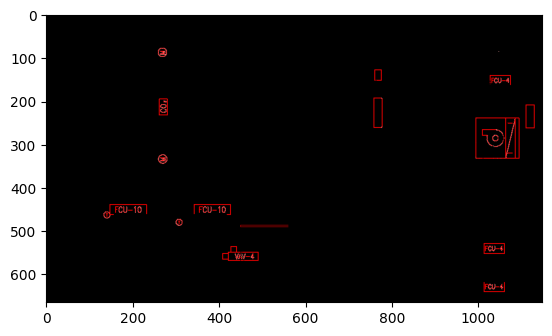

In [ ]:
# red ? H [0, 10]
mask_yellow = cv2.inRange(hsv, np.array([0,40, 40]), np.array([10, 255, 255]))
img_yellow = cv2.bitwise_and(img, img, mask=mask_yellow)
plt.imshow(img_yellow)







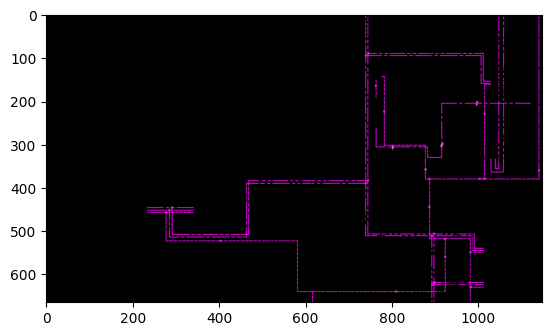

In [ ]:
# purple ? H [140, 160]

mask_yellow = cv2.inRange(hsv, np.array([140,40, 40]), np.array([160, 255, 255]))
img_yellow = cv2.bitwise_and(img, img, mask=mask_yellow)
plt.imshow(img_yellow)




## Object detection using template matching
Template matching is one of the most basic pattern recognition methods. Specifically, it use the squared error to calculate the differents between a template and an original image, with the best match being 0, indicating there is no diferences.

$
R(x, y)=\sum_{x^{\prime}, y^{\prime}}\left(T\left(x^{\prime}, y^{\prime}\right)-I\left(x+x^{\prime}, y+y^{\prime}\right)\right)^{2}\
$


Template matching also has limitations. The algorithm fails if the target is rotated or changed in size in the original image.

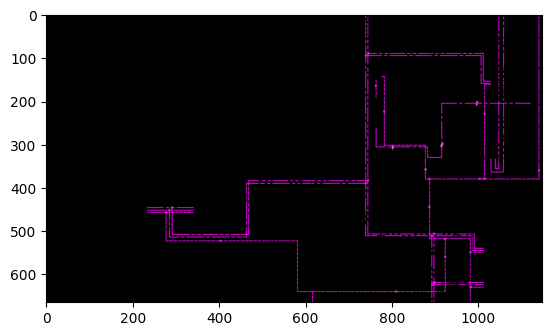

In [ ]:
# show the targets: yellow components
plt.imshow(img_yellow)

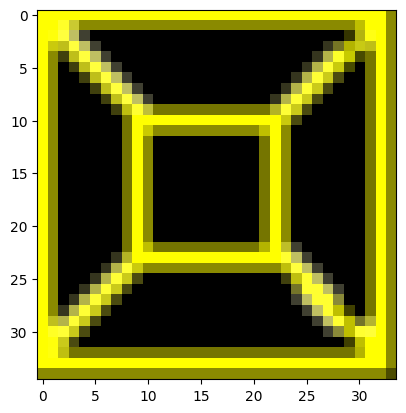

In [ ]:
# load template image
req_yellow_template = urllib.request.urlopen("https://github.com/CrossStyle/MEP2BIM/blob/main/img/yellow_tem.png?raw=true")
yellow_template = np.asarray(bytearray(req_yellow_template.read()), dtype="uint8")
yellow_template = cv2.imdecode(yellow_template, cv2.IMREAD_COLOR)
yellow_template = cv2.cvtColor(yellow_template, cv2.COLOR_BGR2RGB)
theight, twidth = yellow_template.shape[:2]

plt.imshow(yellow_template)

In [ ]:
# template matching
result = cv2.matchTemplate(img_yellow, yellow_template, cv2.TM_SQDIFF_NORMED)

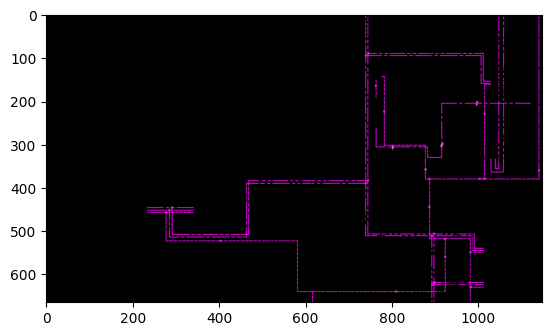

In [ ]:
# Deep copy of the original image, as we are going to draw rectangle in it
# but not going to modify the original one
ori_copy = copy.deepcopy(img_yellow)
# score threshold: 0.5
loc = np.where(result < 0.5)
# draw rectangles
for index, other_loc in enumerate(zip(*loc[::-1])):
    cv2.rectangle(ori_copy, other_loc, (other_loc[0] + twidth, other_loc[1] + theight), (255, 0, 0), 2)
plt.imshow(ori_copy)

In [ ]:
# What happens if we choose different score threshold?


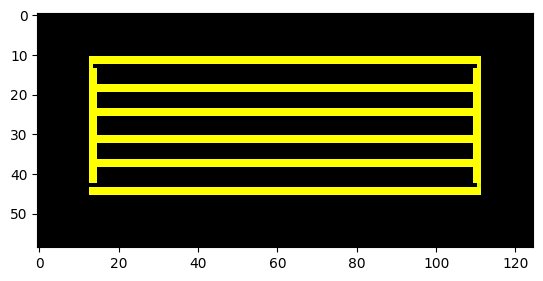

In [ ]:
# Try a more difficult one?
req_yellow_template2 = urllib.request.urlopen("https://github.com/CrossStyle/MEP2BIM/blob/main/img/yellow_tem4.png?raw=true")
yellow_template2 = np.asarray(bytearray(req_yellow_template2.read()), dtype="uint8")
yellow_template2 = cv2.imdecode(yellow_template2, cv2.IMREAD_COLOR)
yellow_template2 = cv2.cvtColor(yellow_template2, cv2.COLOR_BGR2RGB)

plt.imshow(yellow_template2)


In [ ]:
# Next?

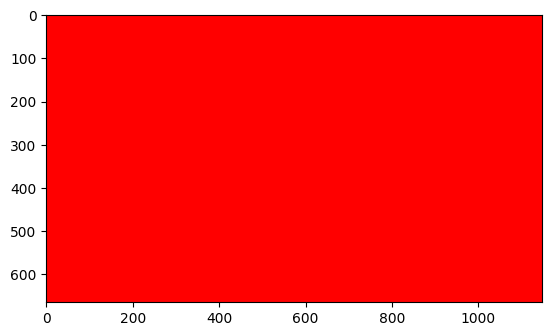

In [ ]:
ori_copy = copy.deepcopy(img_yellow)

theight, twidth = yellow_template2.shape[:2]
result = cv2.matchTemplate(ori_copy, yellow_template2, cv2.TM_SQDIFF_NORMED)
cv2.normalize(result, result, 0, 1, cv2.NORM_MINMAX, -1)
loc = np.where(result < 0.8)
for index, other_loc in enumerate(zip(*loc[::-1])):
    cv2.rectangle(ori_copy, other_loc, (other_loc[0] + twidth, other_loc[1] + theight), (255, 0, 0), 2)
plt.imshow(ori_copy)


## Object detection using feature matching

Quick questions:
1. How do you play jigsaw puzzles?
2. How do you arrange lots of scrambled image pieces into a big single image?

<img src="https://images.maishoudang.com/production/uploads/ueditor_image/image/174544/1503645083.png!large" width="600">

The answer is, we are looking for specific patterns or specific features which are unique, can be easily tracked and can be easily compared.

If we go for a definition of such a feature, we may find it difficult to express it in words, but we know what they are. If someone asks you to point out one good feature which can be compared across several images, you can point out one. That is why even small children can simply play these games. We search for these features in an image, find them, look for the same features in other images and align them. That's it.


### Feature extraction using SIFT (Scale-Invariant Feature Transform)

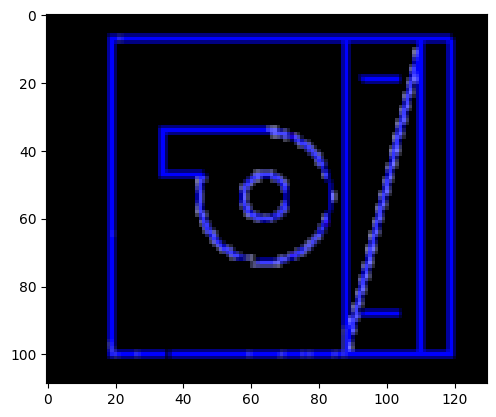

In [ ]:
# load query image
req_target = urllib.request.urlopen("https://github.com/CrossStyle/MEP2BIM/blob/main/img/red1.png?raw=true")
target = np.asarray(bytearray(req_target.read()), dtype="uint8")
template = cv2.imdecode(target, cv2.IMREAD_COLOR)
plt.imshow(template)

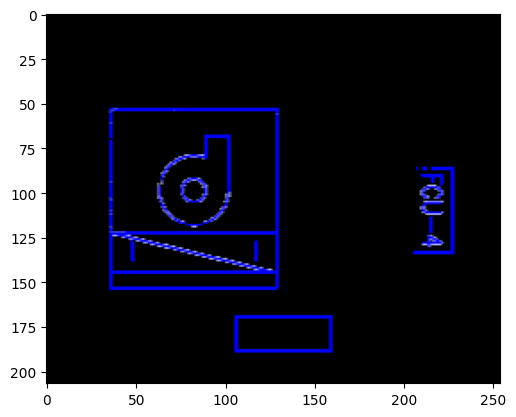

In [ ]:
# load target image
req_target = urllib.request.urlopen("https://github.com/CrossStyle/MEP2BIM/blob/main/img/red3.png?raw=true")
target = np.asarray(bytearray(req_target.read()), dtype="uint8")
target = cv2.imdecode(target, cv2.IMREAD_COLOR)

plt.imshow(target)

In [ ]:
# find the keypoints and descriptors with SIFT
sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(template, None)
kp2, des2 = sift.detectAndCompute(target, None)

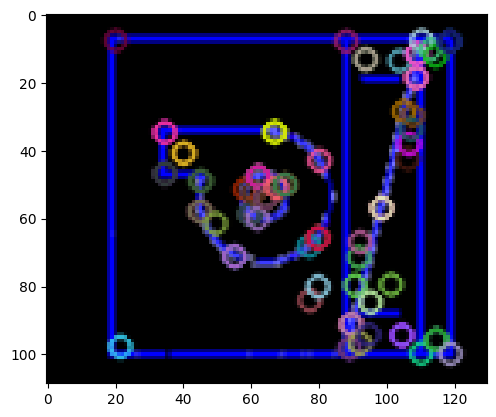

In [ ]:
template_copy = copy.deepcopy(template)
template_copy=cv2.drawKeypoints(template_copy,kp1,template_copy)
plt.imshow(template_copy)

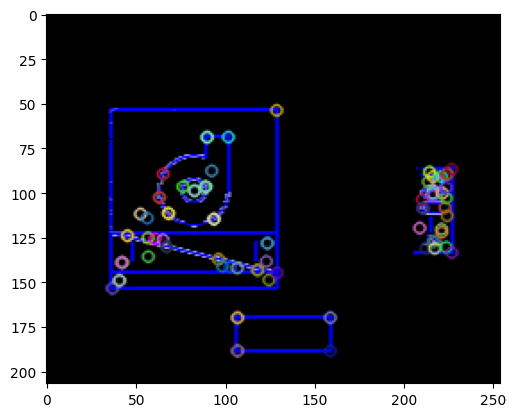

In [ ]:
template_copy1 = copy.deepcopy(target)
template_copy1 = cv2.drawKeypoints(template_copy1,kp2,template_copy1)
plt.imshow(template_copy1)

### FLANN based Matcher
FLANN stands for Fast Library for Approximate Nearest Neighbors. It contains a collection of algorithms optimized for fast nearest neighbor search in large datasets and for high dimensional features.

In [ ]:
index_params = dict(algorithm=1, trees=5)
# algorithm: Specifies the algorithm used to build the KD-tree.
# It can take two values: 1 for KD-tree with a randomized algorithm or 0 for KD-tree with a deterministic algorithm.
# trees: Specifies the number of parallel trees to use. A higher number of trees improves accuracy but increases search time.

search_params = dict(checks=100)
# It specifies the number of times the trees in the index should be recursively traversed.
# Higher values gives better precision, but also takes more time.

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)
# Specify the parameter k=2 for knn, which means that a feature descriptor in image A will
# find two corresponding feature descriptors in image B
# one being the best match with the minimum distance, and the other the next best

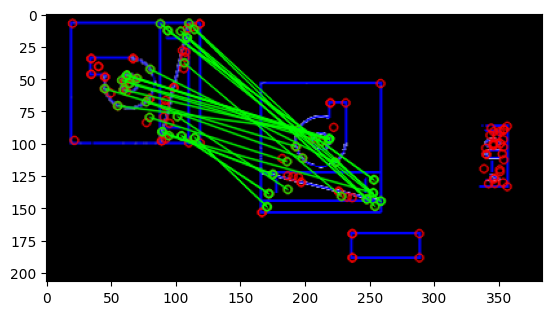

In [ ]:
# visualize the matches
# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# ratio test as per Lowe's paper https://docs.opencv.org/3.4/d5/d6f/tutorial_feature_flann_matcher.html
for i,(m,n) in enumerate(matches):
 if m.distance < 0.7*n.distance:
  matchesMask[i]=[1,0]

draw_params = dict(
    matchColor = (0,255,0),
    singlePointColor = (255,0,0),
    matchesMask = matchesMask,
    flags = cv2.DrawMatchesFlags_DEFAULT
    )
img3 = cv2.drawMatchesKnn(template,kp1,target,kp2,matches,None,**draw_params)
plt.imshow(img3)

It generally suitable for one-on-one matching. Modify is needed for multi-object matching.

Now we set a condition that at least 10 matches (defined by MIN_MATCH_COUNT) for finding the object.

If enough matches are found, we extract the locations of matched keypoints in both the images. They are passed to find the perspective transformation. Once we get this 3x3 transformation matrix, we use it to transform the corners of queryImage to corresponding points in target Image. Then we draw it.

In [ ]:
# find good matches
# store all the good matches as per Lowe's ratio test.
good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)

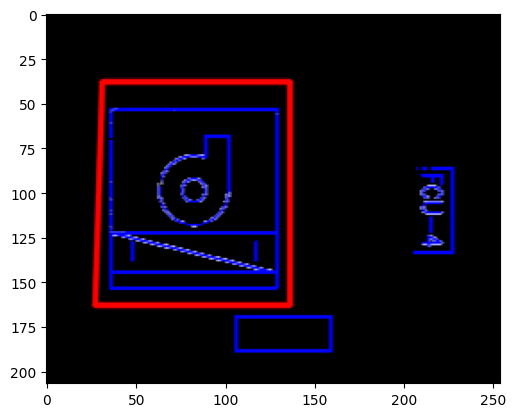

In [ ]:
MIN_MATCH_COUNT = 10
if len(good) > MIN_MATCH_COUNT:
    # locate the good matches,and reshape them into a 3D matrix
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    # calculate tramformation matrix and MASK
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()
    h, w, _ = template.shape

    # tranform the four corners of the queryimage, and draw it on the target image
    pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, M)
    cv2.polylines(target, [np.int32(dst)], True, [255, 0, 0], 2, cv2.LINE_AA)
else:
    print("Not enough matches are found - %d/%d" % (len(good), MIN_MATCH_COUNT))
    matchesMask = None
plt.imshow(target)

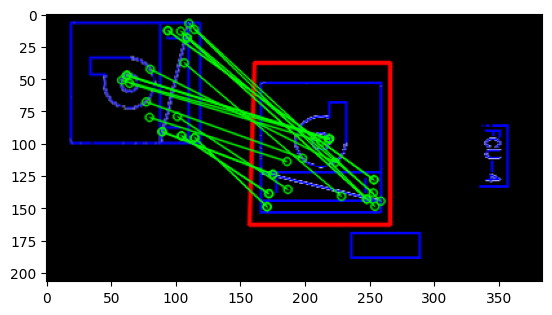

In [ ]:
# visulze results
draw_params = dict(
    matchColor=(0, 255, 0),
    singlePointColor=None,
    matchesMask=matchesMask,
    flags=2)
result = cv2.drawMatches(template, kp1, target, kp2, good, None, **draw_params)
plt.imshow(result)